# Extract PCA Features from Gene Expression

This notebook applies **Principal Component Analysis (PCA)** to the gene expression data from the aligned pseudo-bulk dataset.

The goal is to:
- Reduce dimensionality while retaining most of the biological signal
- Generate a compact representation (PCs) to be used in downstream modeling

We’ll also:
- Visualize explained variance per PC
- Select the number of PCs based on cumulative variance


In [1]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler



In [2]:
aligned = pd.read_parquet("../../data/bulk/rnaseq_fpkm.parquet")
transposed_df = aligned.set_index(aligned.columns[0]).transpose()

# Ensure all values are numeric and fill NAs with zeros or a small value
transposed_df = transposed_df.apply(pd.to_numeric, errors='coerce').fillna(0.0)

# Reset index to turn cell line names into a column
transposed_df.index.name = "SANGER_MODEL_ID"
transposed_df.reset_index(inplace=True)

# Convert back to Polars
cell_gene_matrix = pl.from_pandas(transposed_df)

# Drop unwanted columns
cell_gene_matrix = cell_gene_matrix.drop(["model_name", "dataset_name", "data_source", "gene_id"])

print("Transposed gene expression data to shape: rows = cell lines, cols = genes")
print(f"Shape: {cell_gene_matrix.shape}")
cell_gene_matrix.head()
cell_gene_matrix = cell_gene_matrix.slice(1)

Transposed gene expression data to shape: rows = cell lines, cols = genes
Shape: (1431, 37603)


In [3]:
non_gene_cols = ["SANGER_MODEL_ID"]
gene_cols = [col for col in cell_gene_matrix.columns if col not in non_gene_cols]
sanger_ids = cell_gene_matrix.select("SANGER_MODEL_ID").to_pandas()

X = cell_gene_matrix.select(gene_cols).to_pandas().to_numpy()

# Standardize the expression matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Aligned dataset loaded.")
print(f"Gene matrix shape: {X.shape}")


✅ Aligned dataset loaded.
Gene matrix shape: (1430, 37602)


## 2. Analyze Explained Variance (Scree Plot)

We apply PCA with a large number of components (e.g., 100) to explore:
- How much variance each PC captures
- How many PCs we need to explain 90–95% of total variance

We'll use this to choose the optimal number of components for downstream tasks.


In [4]:
pca_full = PCA(n_components=100, random_state=42)
X_pca_full = pca_full.fit_transform(X_scaled)

explained_var_ratio = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var_ratio)


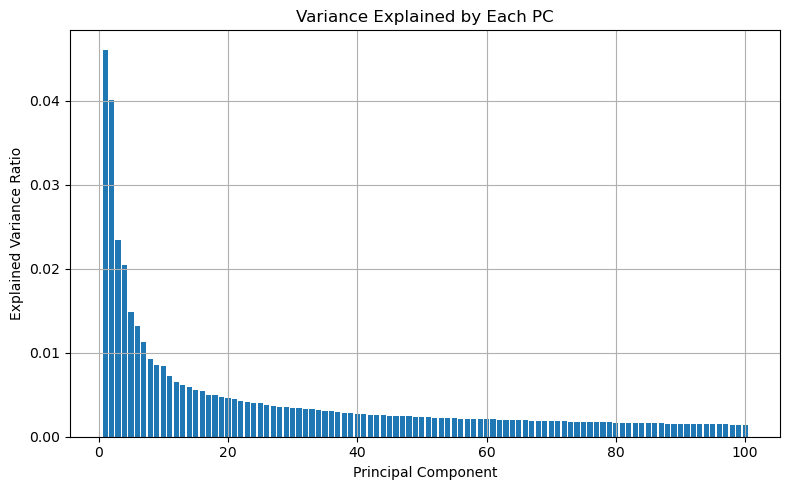

In [5]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_var_ratio) + 1), explained_var_ratio)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Variance Explained by Each PC")
plt.grid(True)
plt.tight_layout()
plt.show()


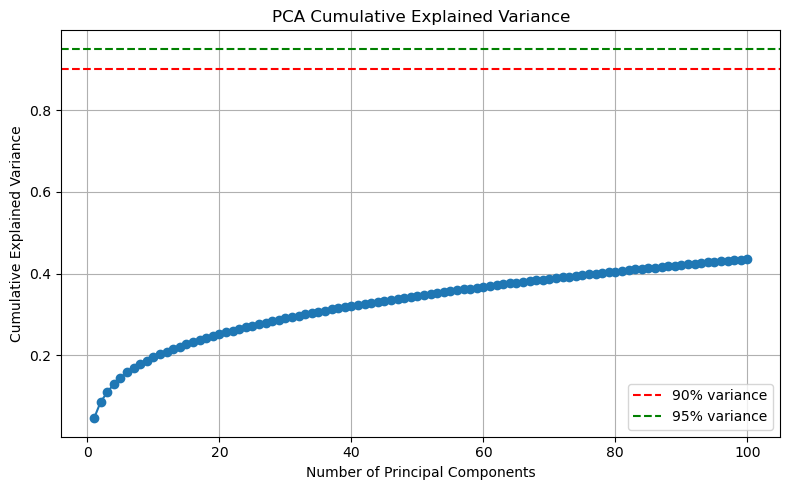

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker="o")
plt.axhline(0.9, linestyle="--", color="red", label="90% variance")
plt.axhline(0.95, linestyle="--", color="green", label="95% variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
n_90 = np.argmax(cumulative_var >= 0.90) + 1
print(f"✅ Number of PCs needed to explain 90% of variance: {n_90}")


✅ Number of PCs needed to explain 90% of variance: 1


## 3. Apply Final PCA with Selected Number of Components

Based on the analysis above, we now apply PCA using the number of components that captures sufficient variance (e.g., 50 or the `n_90` value).


In [8]:
# Set the number of components to retain (either manually or using n_90)
N_COMPONENTS = 20

# Run final PCA
pca_final = PCA(n_components=N_COMPONENTS, random_state=42)
X_pca = pca_final.fit_transform(X_scaled)

# Create column names for PCs
pca_cols = [f"PC{i+1}" for i in range(N_COMPONENTS)]
pca_df = pd.DataFrame(X_pca, columns=pca_cols)

# Reattach the SANGER_MODEL_ID column you stored earlier
pca_df = pd.concat([sanger_ids, pca_df], axis=1)

# Convert to Polars for saving and consistency
final_pl = pl.from_pandas(pca_df)

print("✅ Final PCA applied.")
print(f"Resulting shape: {final_pl.shape}")
final_pl.head()


✅ Final PCA applied.
Resulting shape: (1430, 21)


SANGER_MODEL_ID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SIDM00002""",-38.229049,34.099839,34.401391,3.231617,11.081739,-26.613038,-13.952958,10.833794,-45.038065,7.163383,-24.91474,-23.195696,1.593339,-30.142742,27.772555,21.914606,9.607671,16.469685,-3.779453,-4.069122
"""SIDM00003""",-13.199172,-12.746051,23.043888,15.875985,40.755237,-2.929617,-12.360416,-6.866098,-2.361275,31.189714,29.490421,33.535638,11.90626,-14.29086,8.705482,-6.250157,3.508331,5.222473,1.757384,-1.436788
"""SIDM00005""",-17.877752,72.529898,-13.848899,-80.192304,-70.087121,21.086363,90.498023,12.154957,0.399034,17.736032,-10.688446,-12.454796,35.319478,-58.988835,-76.335,-34.704762,75.66644,-59.814313,16.195981,-3.048903
"""SIDM00006""",-19.761576,-22.81272,32.777658,6.892403,16.441869,-11.187755,-9.073886,6.103976,-2.206305,-5.284102,11.098431,0.144537,-5.585249,-3.680187,-5.341915,10.354124,0.646682,-9.198168,4.112856,-2.740149
"""SIDM00007""",-11.895669,-11.998389,31.254219,9.356441,21.514832,-11.613272,-10.216703,2.824147,-0.692819,-8.347905,6.507762,-8.505207,-10.380024,-4.710645,-18.372567,-9.818753,3.102954,3.861144,-2.147907,-3.726655


## 4. Save PCA-Reduced Dataset

We save the PCA features to a new file, ready for model training or visualization.


In [9]:
# 📥 Load GDSC drug response data
gdsc_bulk = pl.read_parquet("../../data/bulk/gdsc_final_cleaned.parquet").select([
    pl.col("SANGER_MODEL_ID").cast(pl.Utf8),
    pl.col("DRUG_ID").cast(pl.Int32),
    pl.col("LN_IC50").cast(pl.Float32)
])

# 🔗 Merge PCA-transformed cell line profiles with GDSC drug response
merged = gdsc_bulk.join(final_pl, on="SANGER_MODEL_ID", how="left")

# ✅ Confirm merge
print("✅ Merged GDSC with PCA-transformed expression.")
print(f"Final shape: {merged.shape}")
print(merged.head())

# 💾 Save the merged dataset
merged.write_parquet("../../data/bulk/bulk_with_pca.parquet")
print("📁 Saved merged dataset to 'bulk_with_pca.parquet'")


✅ Merged GDSC with PCA-transformed expression.
Final shape: (571985, 23)
shape: (5, 23)
┌────────────┬─────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ SANGER_MOD ┆ DRUG_ID ┆ LN_IC50   ┆ PC1       ┆ … ┆ PC17      ┆ PC18      ┆ PC19      ┆ PC20      │
│ EL_ID      ┆ ---     ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ ---        ┆ i32     ┆ f32       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│ str        ┆         ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
╞════════════╪═════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ SIDM00374  ┆ 1009    ┆ 4.13448   ┆ -28.50541 ┆ … ┆ 53.575456 ┆ 15.126258 ┆ 3.522584  ┆ 7.078355  │
│            ┆         ┆           ┆ 6         ┆   ┆           ┆           ┆           ┆           │
│ SIDM00255  ┆ 268     ┆ -2.236015 ┆ -72.53980 ┆ … ┆ 11.489405 ┆ -33.51771 ┆ 14.455342 ┆ 24.926537 │
│  